# Statistiques descriptives sur l'état de la consommation de cannabis en Europe

In [20]:
!pip install bs4
!pip install nbformat
!pip install pandas
!pip install requests

%run ./Tidy.ipynb

               Recreational                                            Medical
Austria      Decriminalized                                              Legal
Belgium      Decriminalized                                              Legal
Bulgaria            Illegal                                            Illegal
Croatia      Decriminalized                                              Legal
Cyprus              Illegal                                              Legal
Czechia      Decriminalized                                              Legal
Denmark             Illegal                                              Legal
Estonia      Decriminalized                          With a special permit[88]
Finland             Illegal                                              Legal
France              Illegal  A two-year trial program involving 3,000 patie...
Germany               Legal                                              Legal
Greece              Illegal                         

Je m'appuie sur la table dfcurrent. Cette table est très complète et présente pour différentes tranches d'âge de la population européenne, des données de consommation pour un ensemble de drogues qui précisent sa périodicité. Pour rendre cette table la plus lisible possible, nous avons restreint cette table à l'étude du cannabis, puis à la catégorie "Lifetime" qui décrit le fait que les personnes aient déjà consommé une fois au cours de leur vie, tout en séparant la population selon deux catégorisations d'âge. D'un côté la population adulte générale, et d'un autre côté les jeunes de 15 à 34 ans. 

In [21]:
df = pd.read_csv('~/work/Projet_Python_2A/Data/EUDA/edr2024-gps-current-table-1.csv')

dfcurrent = df[df['Substance'] == 'Cannabis']

dfcurrentadults = dfcurrent[dfcurrent['Age'] == 'All adults (15-64)']

dfcurrentadultslf = dfcurrentadults[dfcurrentadults['Recall period'] == 'Lifetime']

print(dfcurrentadultslf.describe())

       Survey year  Prevalence (%)   Sample size  Males (%)  Females (%)
count    29.000000       29.000000     25.000000  29.000000    29.000000
mean   2019.896552       21.524138   6105.680000  26.620690    16.524138
std       2.365599       11.388674   5588.875228  12.834646    10.123616
min    2013.000000        2.700000   1385.000000   5.400000     0.200000
25%    2019.000000       12.200000   3013.000000  17.500000     7.700000
50%    2020.000000       22.700000   4011.000000  27.800000    16.900000
75%    2022.000000       28.800000   7200.000000  34.100000    22.900000
max    2023.000000       47.300000  26344.000000  54.900000    39.900000


Le pourcentage d'adultes qui déclarent avoir déjà consommé du cannabis une fois dans leur vie serait donc de 21,5% en moyenne par pays. Le pays dans laquelle cette consommation est la plus rare est la Turquie avec 2,7% et celui dans laquelle la consommation est la plus haute est la France avec 47,3%.

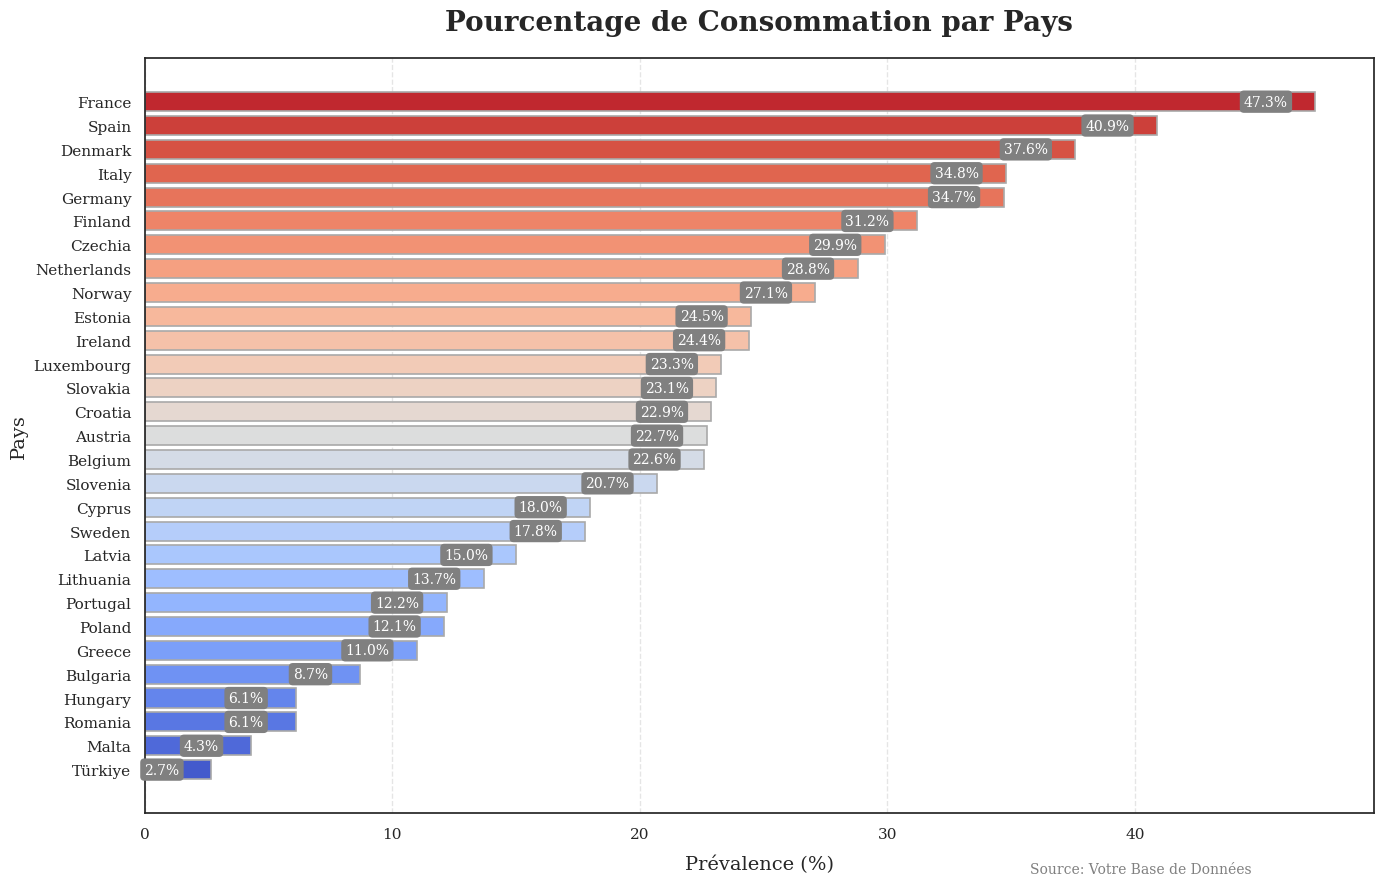

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trier le DataFrame par ordre décroissant de la colonne 'Prevalence (%)'
df_sorted = dfcurrentadultslf.sort_values(by='Prevalence (%)', ascending=False)

# Extraction des données triées
countries = df_sorted['Country']
prevalence = df_sorted['Prevalence (%)']

# Initialisation du style et du graphique
sns.set_theme(style="white", palette="muted", font="serif") 
plt.figure(figsize=(14, 9))  

# Création du graphique en barres horizontales
bars = plt.barh(countries, prevalence, color=sns.color_palette("coolwarm_r", len(countries)), edgecolor='darkgray', linewidth=1.2)

# Inverser l'ordre des pays pour correspondre au tri décroissant
plt.gca().invert_yaxis()

# Ajout des titres et labels stylisés
plt.title('Pourcentage de Consommation par Pays', fontsize=20, weight='bold', pad=20)
plt.xlabel('Prévalence (%)', fontsize=14, labelpad=10)
plt.ylabel('Pays', fontsize=14)

# Affichage des valeurs sur les barres avec des bulles arrondies
for bar, value in zip(bars, prevalence):
    plt.text(bar.get_width() - 2,                
             bar.get_y() + bar.get_height() / 2, 
             f"{value:.1f}%",                   
             ha='center', va='center', 
             color='white', fontsize=10, 
             bbox=dict(facecolor='gray', edgecolor='none', boxstyle='round,pad=0.3'))  

# Personnalisation des axes
plt.tick_params(axis='both', which='major', labelsize=11)  
plt.grid(axis='x', linestyle='--', alpha=0.5)             

# Ajustement des marges pour un meilleur rendu
plt.tight_layout()

# Ajout d'une légende
plt.figtext(0.9, 0.02, 'Source: Votre Base de Données', ha='right', fontsize=10, color='gray')

# Affichage
plt.show()


Nous retrouvons avec ce graphique l'écart important entre la France et la Turquie (Türkiye). La visualisation des données sur ce graphique nous amène à un certain nombre de questionnements sur les écarts de consommation entre les différents pays européens et notamment entre les pays qui ont des écarts de consommation importants malgré des caractéristiques socio-économiques, voire culturelles proches. Par exemple, on observe un écart de 27 points de pourcentage entre la prévalence en France et en Belgique (Belgium), alors même que ces deux pays sont voisins, partagent une langue commune, et des caractéristiques socio-économiques similaires. 
Pour prendre un autre exemple, nous allons nous intéresser aux pays baltes. Il ne parait pas irréaliste de prétendre que la Lettonie (Latvia), la Lituanie (Lithuania) et l'Estonie (Estonia) peuvent être comparés de manière pertinente. Si le pourcentage de prévalence est quasiment le même entre la Lettonie et la Lituanie, entre 14 et 15%, il est de 24,5% en Estonie.
On doit s'interroger sur les paramètres qui peuvent expliquer ces différences alors que dans une première approche naïve, on peut considérer que ces pays ont des caractéristiques très proches. 

Pour améliorer la visualisation de nos données, nous réalisons une carte choroplèthe de la prévalence en Europe.

/tmp/ipykernel_5871/1074800557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcurrentadultslf['Country'] = dfcurrent['Country'].replace('Türkiye', 'Turkey')


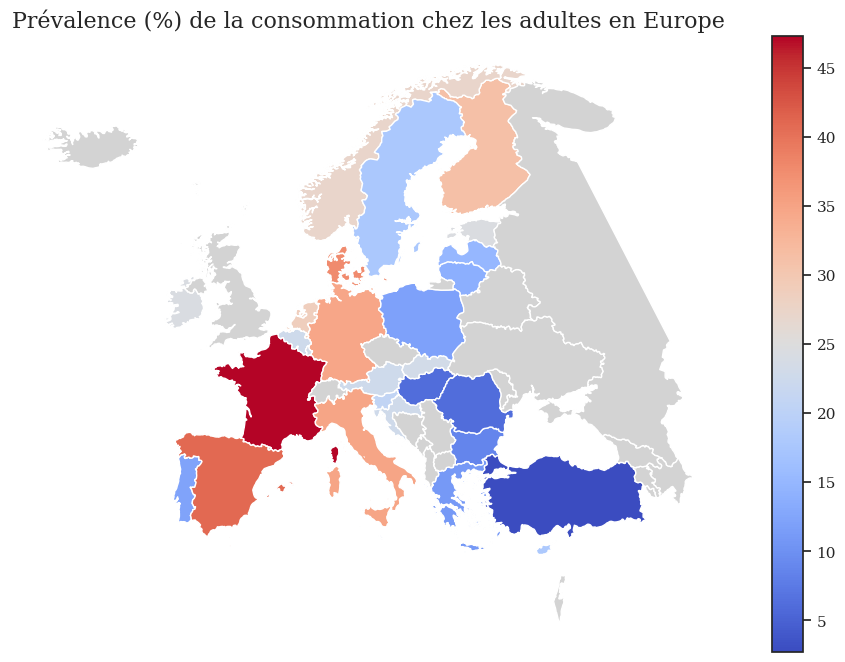

In [23]:
!pip install pandas fiona shapely pyproj rtree geopandas
import pandas as pd
import geopandas as gpd

# Charger le fond de carte de l'Europe
europe_map = gpd.read_file("https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson")

#Je recode le nom de la Turquie pour qu'il corresponde dnas les deux bases
dfcurrentadultslf['Country'] = dfcurrent['Country'].replace('Türkiye', 'Turkey')

europe_map = europe_map.rename(columns={'NAME': 'Country'})

# Fusionner le fond de carte avec les données
merged = europe_map.merge(dfcurrentadultslf, on="Country", how="left")

# Créer une carte choroplèthe
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column="Prevalence (%)", cmap="coolwarm", legend=True, ax=ax, missing_kwds={
    "color": "lightgrey",
    "label": "No data"
})
ax.set_title("Prévalence (%) de la consommation chez les adultes en Europe", fontsize=16)
ax.axis("off")
plt.show()


Nous voulons désormais réaliser des analyses comparables, mais en considérant uniquement la tranche d'âge des 15-34 ans, qui sont probablement plus exposés à cette consommation. On crée donc une table "dfcurrentyoung". 

In [24]:
dfcurrentyoung = dfcurrent[dfcurrent['Age'] == 'Young adults (15-34)']

dfcurrentyounglf = dfcurrentyoung[dfcurrentyoung['Recall period'] == 'Lifetime']

print(dfcurrentyounglf.describe())

       Survey year  Prevalence (%)  Sample size  Males (%)  Females (%)
count    28.000000       28.000000     25.00000  27.000000    27.000000
mean   2020.142857       29.935714   2214.92000  35.129630    24.874074
std       1.994702       13.229798   2262.94548  14.702873    12.759027
min    2015.000000        3.900000    442.00000   7.300000     0.400000
25%    2019.000000       21.950000    927.00000  25.700000    15.050000
50%    2020.000000       32.450000   1627.00000  36.600000    27.600000
75%    2022.000000       39.975000   2550.00000  46.650000    32.750000
max    2023.000000       54.500000  11495.00000  60.400000    48.800000


Le pourcentage de 15-34 ans qui déclarent avoir consommé du cannabis au moins une fois dans leur vie est donc de 29,9% par pays, soit 8 points de pourcentage de plus que pour la population générale. Les valeurs extrêmes sont également plus élevées, même si elles concernent toujours la Turquie et la France. L'hypothèse selon laquelle la consommation est sujette à un effet d'âge semble valide. Davantage de jeunes de 15-34 ans déclarent, dans tous les pays, avoir consommé du cannabis une fois dans leur vie par rapport à la population générale. Cet écart est d'autant plus important que cette catégorie d'âge est intégrée à la population générale et donc quelle contribue à augmenter la valeur de la prévalence dans la population générale. Si l'on comparait la prévalence des 15-34 ans à celle des 34-64 ans, on aurait donc un écart plus grand. 

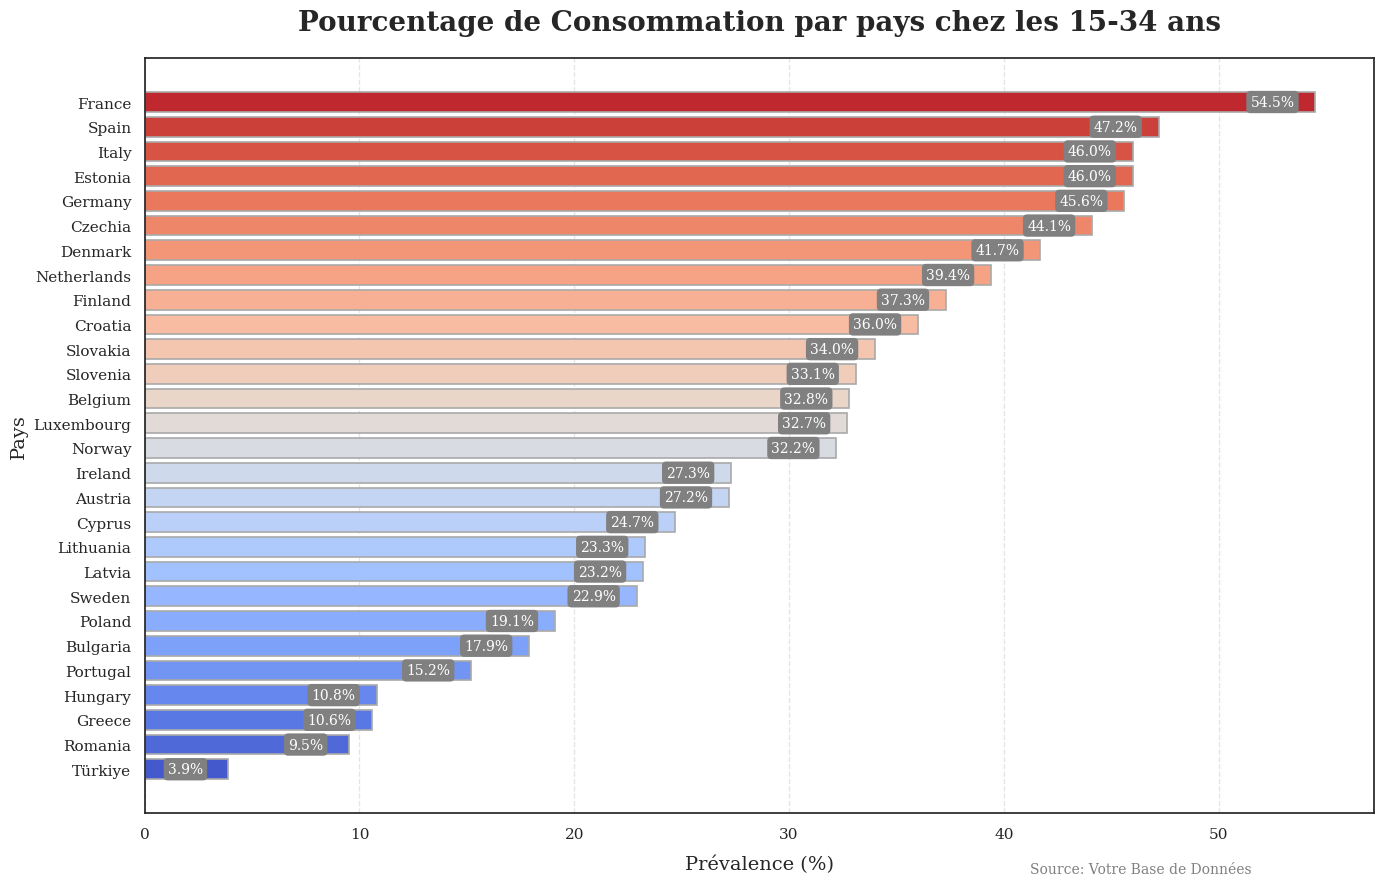

In [25]:
# Trier le DataFrame par ordre décroissant de la colonne 'Prevalence (%)'
df_sorted = dfcurrentyounglf.sort_values(by='Prevalence (%)', ascending=False)

# Extraction des données triées
countries = df_sorted['Country']
prevalence = df_sorted['Prevalence (%)']

# Initialisation du style et du graphique
sns.set_theme(style="white", palette="muted", font="serif") 
plt.figure(figsize=(14, 9))  

# Création du graphique en barres horizontales
bars = plt.barh(countries, prevalence, color=sns.color_palette("coolwarm_r", len(countries)), edgecolor='darkgray', linewidth=1.2)

# Inverser l'ordre des pays pour correspondre au tri décroissant
plt.gca().invert_yaxis()

# Ajout des titres et labels stylisés
plt.title('Pourcentage de Consommation par pays chez les 15-34 ans', fontsize=20, weight='bold', pad=20)
plt.xlabel('Prévalence (%)', fontsize=14, labelpad=10)
plt.ylabel('Pays', fontsize=14)

# Affichage des valeurs sur les barres avec des bulles arrondies
for bar, value in zip(bars, prevalence):
    plt.text(bar.get_width() - 2,                
             bar.get_y() + bar.get_height() / 2, 
             f"{value:.1f}%",                   
             ha='center', va='center', 
             color='white', fontsize=10, 
             bbox=dict(facecolor='gray', edgecolor='none', boxstyle='round,pad=0.3'))  

# Personnalisation des axes
plt.tick_params(axis='both', which='major', labelsize=11)  
plt.grid(axis='x', linestyle='--', alpha=0.5)             

# Ajustement des marges pour un meilleur rendu
plt.tight_layout()

# Ajout d'une légende
plt.figtext(0.9, 0.02, 'Source: Votre Base de Données', ha='right', fontsize=10, color='gray')

# Affichage
plt.show()

Ce graphique confirme que la prévalence est plus élevée pour chacun des pays pour les 15-34 ans par rapport à la population générale. Si on reprend les pays que nous avons utilisés dans notre première comparaison, il y a toujours un écart de 20 points de pourcentage entre la France et la Belgique. En ce qui concerne les pays baltes, nous avons un schéma également similaire à la population générale, la Lettonie et la Lituanie possédant des pourcentages de prévalence très proches, alors que l'écart avec l'Estonie est encore accru. 

/tmp/ipykernel_5871/1017965273.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcurrentyounglf['Country'] = dfcurrent['Country'].replace('Türkiye', 'Turkey')


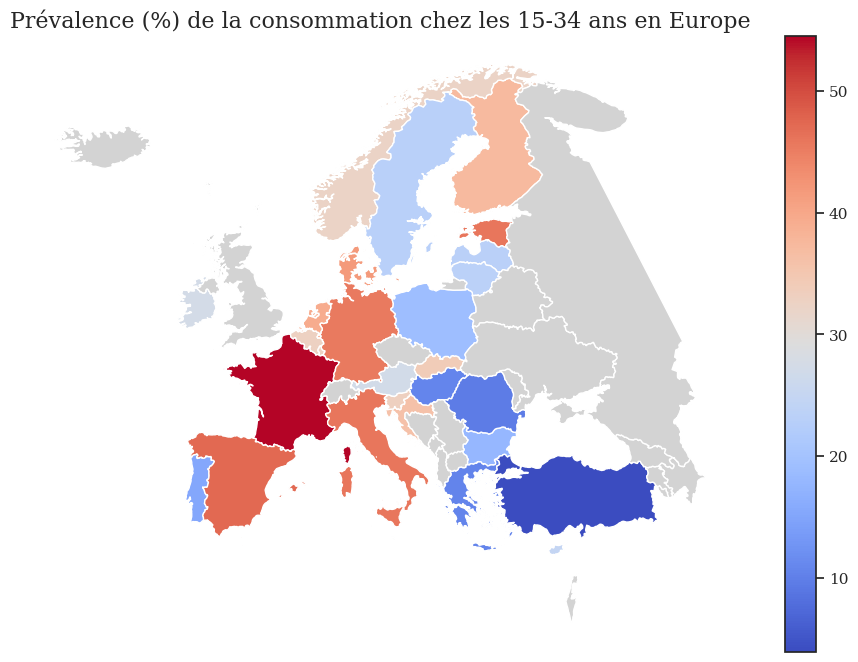

In [26]:
# Charger le fond de carte de l'Europe
europe_map = gpd.read_file("https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson")

europe_map = europe_map.rename(columns={'NAME': 'Country'})

#Je recode le nom de la Turquie pour qu'il corresponde dnas les deux bases
dfcurrentyounglf['Country'] = dfcurrent['Country'].replace('Türkiye', 'Turkey')


# Fusionner le fond de carte avec les données
merged = europe_map.merge(dfcurrentyounglf, on="Country", how="left")


# Créer une carte choroplèthe
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column="Prevalence (%)", cmap="coolwarm", legend=True, ax=ax, missing_kwds={
    "color": "lightgrey",
    "label": "No data"
})
ax.set_title("Prévalence (%) de la consommation chez les 15-34 ans en Europe", fontsize=16)
ax.axis("off")
plt.show()

Pour résumer les premières observations que nous avons fait dans cette partie, nous avons remarqué dans notre première phase d'analyse des différences de prévalence entre des pays que nous considérons comme possédant des caractéristiques socio-économiques similaires. Ces différences peuvent aller du simple au double dans le cas des pays baltes. Deux directions semblent intéressantes pour avancer dans notre problématique. Soit tenter dans un premier temps d'expliquer ces différences par des différences qui n'auraient pas à voir avec les caractéristiques socio-économiques, ce que nous allons faire dans notre analyse portant sur les différences de législation. Ou alors dans un second temps d'expliquer ces différences par des données plus fines sur les caractéristiques socio-économiques, au-delà d'a priori naïfs. 

Nous allons commencer par nous intéresser à la législation dans les pays européens, à partir des données scrapées sur wikipédia. 

In [27]:
legal_pays_clean = legal_pays_clean.reset_index()
legal_pays_clean.rename(columns={'index': 'Country'}, inplace=True)

legal_pays_clean.head()

,Country,Recreational,Medical
0,Austria,Decriminalized,Legal
1,Belgium,Decriminalized,Legal
2,Bulgaria,Illegal,Illegal
3,Croatia,Decriminalized,Legal
4,Cyprus,Illegal,Legal


Nous allons créer une carte permettant de visualiser l'état de la légalisation en Europe. Les pays dans lesquels sa consommation récréative est illégale seront représentés en rouge, ceux dans lesquels la consommation récréative est légale seront représentés en vert, et enfin ceux dans lesquels cette consommation est décriminalisée seront représentés en bleu. 

In [ ]:
import folium
import geopandas as gpd

# Charger les données géographiques des pays d'Europe depuis le fichier téléchargé
world = gpd.read_file("~/work/Projet_Python_2A/Data/ne_110m_admin_0_countries.shp")

# Filtrer pour ne garder que les pays européens
europe = world[(world['CONTINENT'] == 'Europe') | (world['NAME'] == 'Turkey')]

#Renommer la Turquie pour la faire correspondre
legal_pays_clean['Country'] = legal_pays_clean['Country'].replace('Türkiye', 'Turkey')

# Créez la carte avec un fond Google Maps
m = folium.Map(location=[54.5260, 15.2551], zoom_start=4, tiles='CartoDB positron')

# Définir une fonction pour colorier les pays selon la modalité de la variable 'Recreational'
def get_color(value):
    if value == "Legal":
        return "green"
    elif value == "Illegal":
        return "red"
    elif value == "Decriminalized":
        return "blue"
    else:
        return "gray"

# Ajouter un geoJSON des pays à la carte
for _, row in europe.iterrows():
    country_name = row['NAME']
    country_data = legal_pays_clean[legal_pays_clean['Country'] == country_name]
    
    if not country_data.empty:
        recreational_status = country_data['Recreational'].values[0]
    else:
        recreational_status = None

    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, recreational_status=recreational_status: {
            'fillColor': get_color(recreational_status),
            'fillOpacity': 0.7,
            'weight': 0.5,
            'color': 'black'
        }
    ).add_to(m)

# Afficher la carte 
m



Les pays que nous utilisions auparavant pour nos comparaisons, en les considérant comme similaires, présentent des différents dans la législation. En effet, la consommation de cannabis est dépénalisée en Belgique, alors qu'elle est illégale en France. La repression pénale du cannabis pourrait alors augmenter sa consommation. 
Cependant, si on prend le cas des pays baltes, c'est l'effet inverse qui est observé. L'Estonie, qui se démarquait par une prévalence deux fois plus élevées que les pays voisins a légalisé la consommation de cannabis, contrairement à la Lituanie et à la Lettonie. Ici, la légalisation pourrait donc au contraire entraîner une hausse de la consommation. Ces deux exemples nous montrent que le lien entre la législation et la consommation n'est pas évident. 